# Segmentacion mediante crecimiento por regiones
#### Grupo 1: Mariana Nakagawa, María Pardo y Gema Perez.

Índice de los pasos a seguir:
1. Preparación de imágenes 
2. Implementación algoritmo: Crecimiento de regiones
3. Resultados finales
4. Otros ejemplos
5. Mejoras del algoritmo
6. Referencias
7. Autoría

## 1. Preparación de las imágenes

##### Importación de librerías

En esta sección vamos a proceder a visualizar las imágenes que hemos obtenido del repositorio de bases de datos Open Neuro, para poder evaluar los resultados de filtrado que debemos realizar. 

En primer lugar, cargaremos las imágenes con las que testearemos nuestro código. Se trata de imágenes de fMRI.

In [2]:
import os
import numpy as np
import nibabel as nib #nos permite leer las imagenes
import matplotlib 
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
from nilearn import plotting
import modules
#%matplotlib inline

In [5]:
img1 = nib.load(r'\Users\nakag\OneDrive\Escritorio\squizo\sub-02\anat\sub-02_T1w.nii.gz')

In [6]:
data = img1.get_fdata()  

In [7]:
print(data.shape)

(176, 256, 256)


In [8]:
print(data.dtype, img1.get_data_dtype())

float64 float32


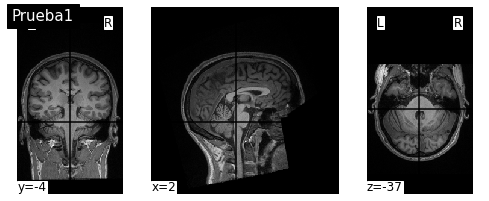

In [9]:
plotting.plot_img(img1, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()     

Para poder realizar el algoritmo, vamos a transformar los datos al formato array, y tras ello guardaremos un único corte (que hemos elegido de manera aleatoria) al que realizaremos la adición. 
​
> En caso de querer disminuir el tiempo de ejecución descomente una de las líneas para disminuír el tamaño de las imágenes y por ende, el número de píxeles a analizar.<pre><code>a = np.array(skimage.transform.resize(img1.dataobj, (50,70)))
a = np.array(skimage.transform.rescale(img.dataobj,0.3))
</code></pre> Y comente la línea:<pre><code>a = np.array(img1.dataobj)
</code></pre>

In [10]:
#Vamos a probar los algoritmos con imágenes más pequeñas para disminuir el tiempo de computación
a = np.array(skimage.transform.resize(img1.dataobj, (120,160)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
#a = np.array(img1.dataobj)
a.shape

(120, 160, 256)

Una resonancia obtiene imagenes en 3D, por lo que a la hora de analizar el array obtenido, debemos tener en cuenta que las tres posiciones que obtenemos corresponden a:
1. La altura de la imagen.
2. El ancho de la imagen.
3. El número de corte.

Para poder analizar las imágenes, escogeremos un corte intermedio (128).

Normalizaremos las frecuencias de las imágenes, de forma que el rango de este nuevo histograma sea [0,1] Es decir, dividimos cada frecuencia entre el total de píxeles de la imagen.

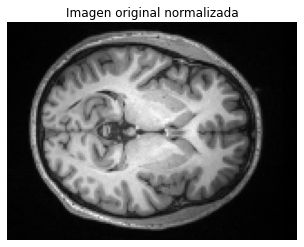

In [11]:
img_gray= a[:,:,128]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(img_o, cmap=plt.cm.gray)


## 2.Conceptos teóricos del algoritmo: Crecimiento por regiones

El **crecimiento de regiones** se basa en localizar píxeles con intensidades similares según un determinado criterio de homogeneidad. En este caso, partimos de la idea de que la región a segmentar es una región homogénea desde algún punto de vista, y que es diferente de otras regiones.

El proceso de crecimiento de regiones se inicia seleccionando un determinado píxel (o grupo de ellos) de la zona de interés, denominado semilla (seed), de forma interactiva o automática. En pasos sucesivos, se comparan los píxeles contiguos a la semilla y se añaden a la ROI si cumplen alguna condición de homogeneidad. Este proceso se repite hasta que se recorre dejan de existir píxeles contiguos homogéneos.

Para realizar el crecimiento de regiones, hay que tener en cuenta cómo definimos la **conectividad o vecindad** entre píxeles.En este caso vamos a comparar el píxel inicial con todos sus píxeles adyacentes, hablamos de vecindad a 8. El utilizar un tipo de conectividad u otra puede tener consecuencias en el resultado final, ya que la vecindad a 4 es mucho más restrictiva. Cuanto menor sea la vecindad que vamos a definir, más restrictivo espacialmente será el crecimiento de regiones, es por ello por lo que elegimos una vecindad a 8. 

Por lo tanto, este método de segmentación usa un conjunto de semillas como parámetro las que marcarán la zona a segmentar. Uno de los criterios de homogeneidad se basa en introducir un **rango de niveles de gris** en torno al valor de la semilla, definiendo de tal modo una condición a la hora de segmentar nuestra región.


## 3. Flujo de la función.RegionGrowingP2() creada

Implementamos la función **.RegionGrowingP2** del fichero **modules.py**, que tiene como parámetros de entrada la imagen a segmentar, y el rango de gris de la región (umbral_inf y umbral sup).

Para seleccionar la semilla usamos la función **ginput** del paquete matplotlib. 

Una vez marcada la semilla, nos interesa recorrer los puntos de alrededor de la misma, es decir usar conectividad a 8. En la conectividad a 8, los píxeles están conectados si sus bordes o esquinas se tocan. Dos píxeles adyacentes forman parte del mismo objeto si están conectados a lo largo de la dirección horizontal, vertical o diagonal. Seleccionando estos píxeles evaluaremos si sus valores de gris están en torno al valor de la semilla. Para ello, vamos a utilizar los umbrales introducidos en la definición de la función:

 * Si el valor de gris del píxel está dentro del intervalo umbral_inf<seed<umbral_sup, añado esa coordenada a la región y continúo iterando.
 * Si no lo está, no lo añado y continúo iterando.
    
>Este algoritmo recursivo finaliza una vez analizado todos los pixeles adyayacentes que cumplan el criterio de homogeneidad.


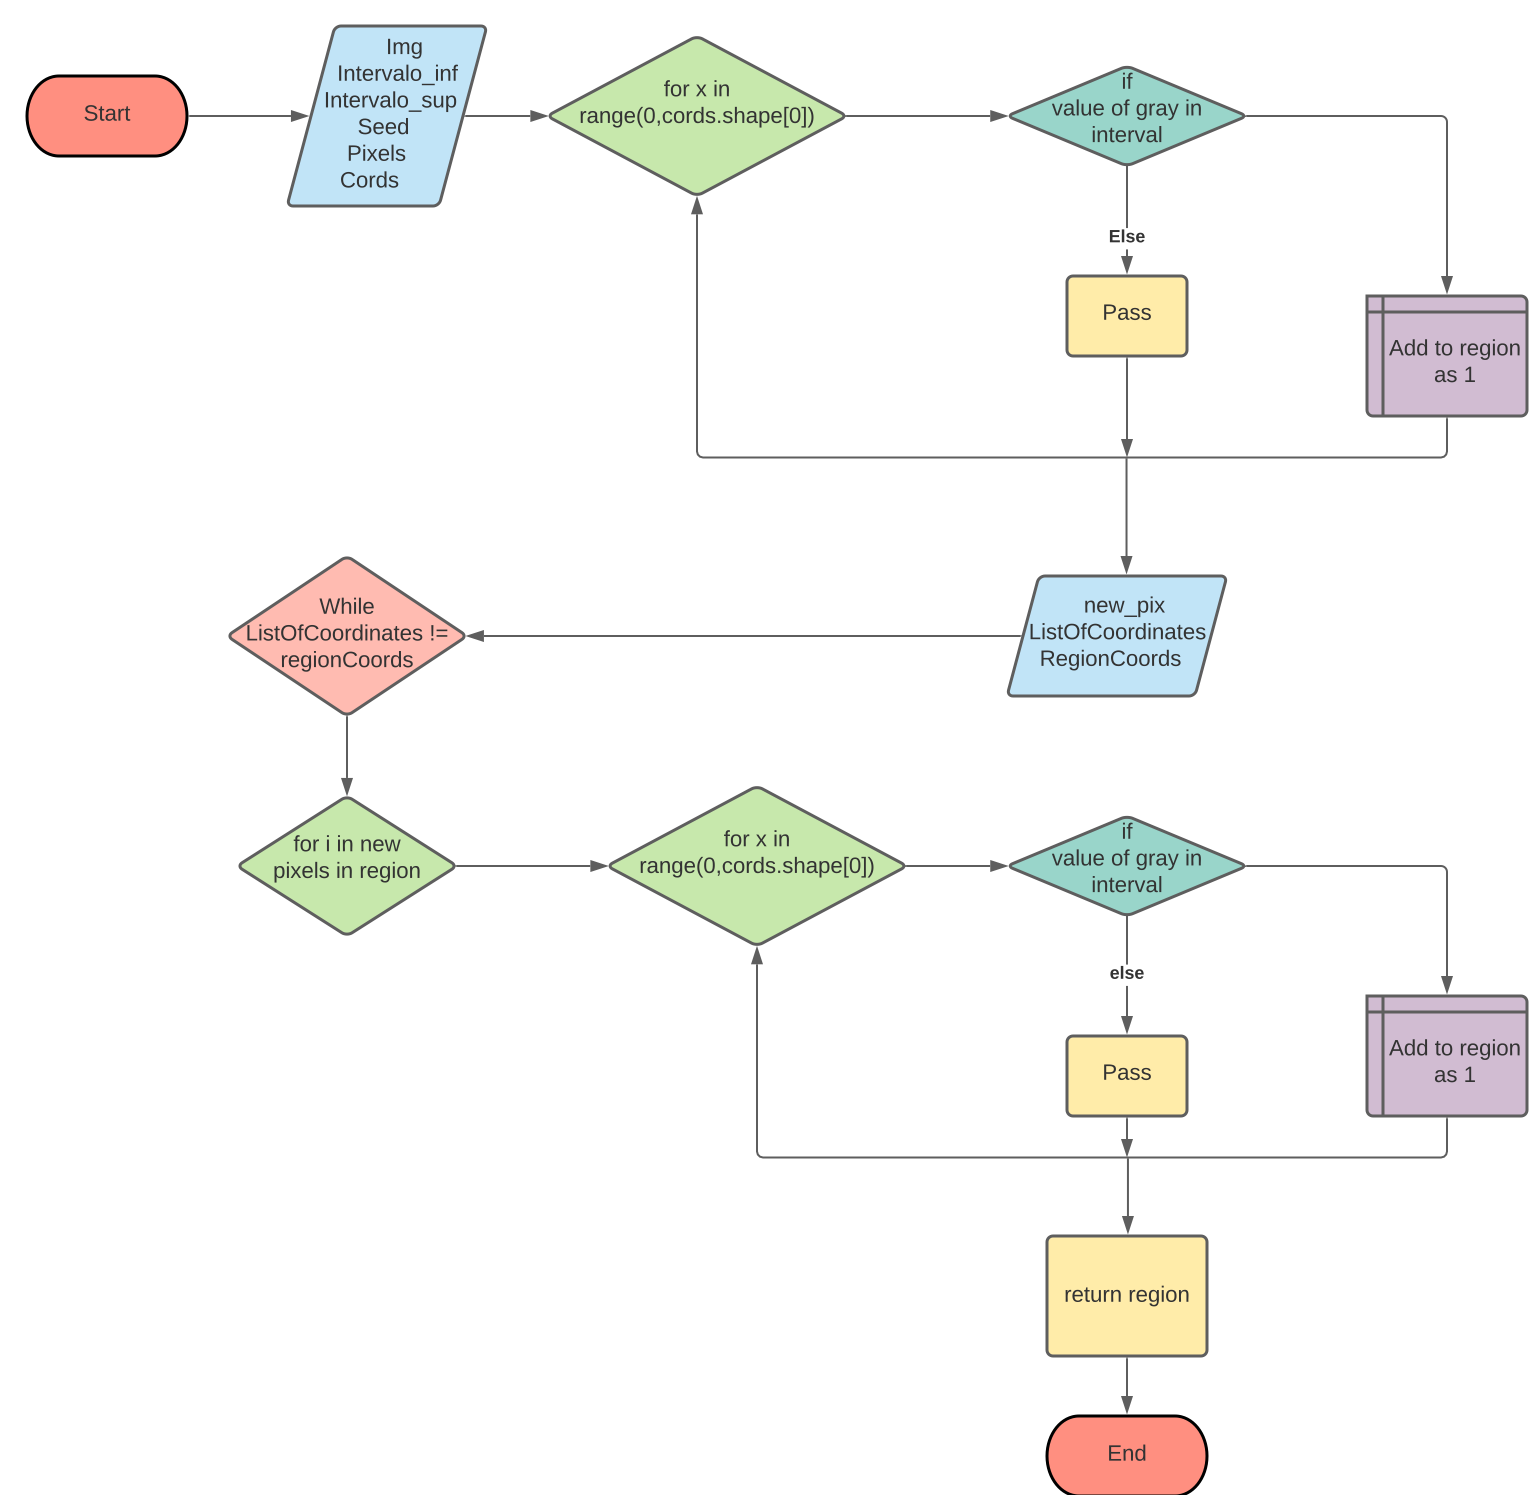

## 3. Ejemplo y discusión de los resultados


### Sustancia blanca, gris y negra

En este apartado implementaremos el algoritmo para segmentar tres regiones anatómicas características de nuestra imagen:

*  **Sustancia blanca**: es una parte del sistema nervioso central compuesta de fibras nerviosas mielinizadas. Estas fibras nerviosas contienen sobre todo muchos axones. 

*   **Sustancia gris**: esta zona corresponde a aquellas zonas del sistema nervioso central de color grisáceo integradas principalmente por somas neuronales y axones carentes de mielina junto con células gliales.

*   **Sustancia negra**: es una porción heterogénea del mesencéfalo (localizada en la zona superior del encéfalo), y un elemento importante del sistema de ganglios basales. La parte compacta contiene neuronas que en los humanos se tiñen de negro con el pigmento neuromelanina que disminuye con la edad. 




En primer lugar, vamos a realizar un estudio del rango de valores de gris mediante la visualización de un **histograma**. Esto lo hacemos con el propósito de ver si es posible diferenciar regiones anatómicas a partir de sus diferentes niveles de gris. 

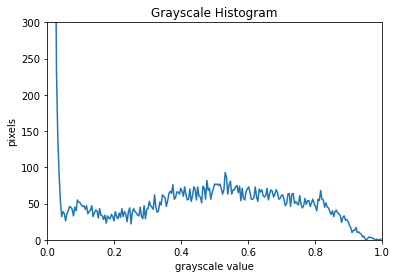

In [46]:
# create the histogram
histogram, bin_edges = np.histogram(img_o, bins=256, range=(0, 1))

# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here
plt.ylim([0.0,300.0])

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

Como podemos observar, obtenemos un histograma bastante plano por lo que no podemos diferenciar a simple vista ningún intervalo de gris en el que podamos caracterizar alguna estructura anatómica. Por ello tendremos que basarnos en un criterio interactivo y visual.

Para poder elegir la posición de la semilla es necesario tener un conocimiento previo de la región a segmentar, en nuestro caso, sustancia blanca, gris y negra. 

Ahora bien, ¿cómo afectaría la posición de la semilla a la hora de segmentar una misma región? 
Debemos tener en cuenta que con nuestra función **.RegionGrowingP2()** vamos a tomar como pixel de referencia aquel que hemos introducido en seed. Dependiendo del valor de gris de este pixel, el intervalo que tomamos como criterio de unión a la región cambiará, por lo que la segmentación será diferente. 

En el caso de la sustancia blanca, podemos diferenciar que hay diferentes valores de gris pertenecientes a la región en concreto. Por ello, el intervalo de grises que asumiremos que forman parte de esta región será más amplio. Si nos fijamos en la porción posterior del encéfalo correspondiente a la sustancia blanca, el nivel de gris es más oscuro que en la parte medial, a pesar de pertenecer a la misma estructura anatómica.

Sin embargo, en el caso de sustancia gris y negra, necesitaremos limitar dicho intervalo para realizar correctamente la segmentación. Esto es debido a que el rango de grises que caracterizan a estas estructuras es más reducido. 

In [47]:
%matplotlib auto
regiones = modules.RegionGrowingP2(img_o, 0.3, 0.1)
regiones2 = modules.RegionGrowingP2(img_o, 0.15, 0.1)
regiones3 = modules.RegionGrowingP2(img_o, 0.1, 0.15)

Using matplotlib backend: Qt5Agg
[37, 66]
[23, 58]
[31, 123]


(Text(0.5, 1.0, 'Sustancia Negra'), (-0.5, 159.5, 119.5, -0.5))

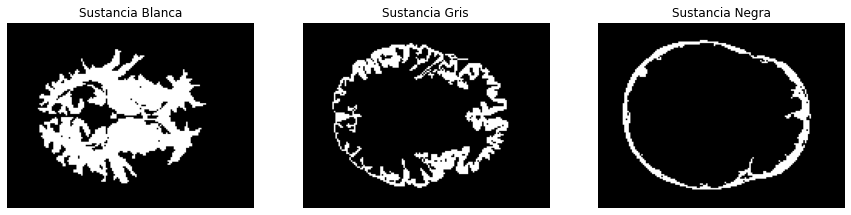

In [48]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(regiones, cmap=plt.cm.gray)

plt.title('Sustancia Blanca'), plt.axis('off')
plt.subplot(132)
plt.imshow(regiones2, cmap=plt.cm.gray)

plt.title('Sustancia Gris'), plt.axis('off')

plt.subplot(133)
plt.imshow(regiones3, cmap=plt.cm.gray)

plt.title('Sustancia Negra'), plt.axis('off')

Al representar nuestras segmentaciones sobre la imagen original demostramos que nuestro algoritmo **está segmentando correctamente las regiones anatómicas** que hemos mencionado con anterioridad.

(Text(0.5, 1.0, 'Sustancia Negra'), (-0.5, 159.5, 119.5, -0.5))

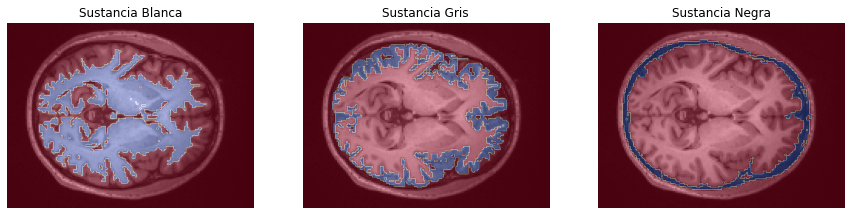

In [49]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(img_o, cmap=plt.cm.gray)
plt.imshow(regiones, cmap='coolwarm_r', alpha=0.4)

plt.title('Sustancia Blanca'), plt.axis('off')
plt.subplot(132)
plt.imshow(img_o, cmap=plt.cm.gray)
plt.imshow(regiones2, cmap='coolwarm_r', alpha=0.4)

plt.title('Sustancia Gris'), plt.axis('off')

plt.subplot(133)
plt.imshow(img_o, cmap=plt.cm.gray)
plt.imshow(regiones3,cmap='coolwarm_r', alpha=0.4)

plt.title('Sustancia Negra'), plt.axis('off')

Como podemos observar, cada región comienza a formarse a partir del pixel semilla y va evolucionando, mediante un algoritmo recursivo, por incorporación de aquellos pixeles vecinos a los ya integrados. 

Es necesario que los umbrales, tanto inferior como superior sean lo más ajustados posibles para evitar una mala segmentación de la región de interés. Además, nuestra imagen no es muy ruidosa, lo cual nos favorece a la hora de implementar el algoritmo. 

Por tanto, seleccionando nuestra semilla podemos diferenciar distintas regiones de interés como son la sustancia blanca, la sustancia gris y la sustancia negra. 

En la tercera imagen correspondiente a la sustancia negra, podemos observar que no ocupa tanta área como las otras dos regiones porque anatómicamente se localiza en la parte superior del tronco del encéfalo. Debido a la altura de nuestro corte axial, no se puede apreciar en su totalidad. Para poder verlo mejor sería preciso tomar un corte más próximo a la región inferior del cerebro. 


## 5. Otros ejemplos

A continuación, vamos a segmentar en otra imagen de nuestra base de datos diferentes zonas anatómicas como comprobación de la capacidad de nuestro algoritmo. Elegimos un corte sagital, en el que podemos segmentar el cuerpo calloso, el septo pelúcido y parte del tronco cerebral.

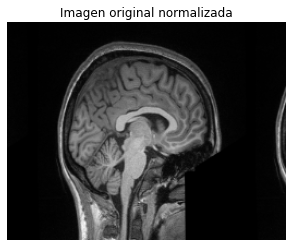

In [20]:
img1 = nib.load(r'\Users\nakag\OneDrive\Escritorio\squizo\sub-03\anat\sub-03_T1w.nii.gz')
data = img1.get_fdata()  
a = np.array(skimage.transform.resize(img1.dataobj, (140,200)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
#a = np.array(img1.dataobj)
a.shape
img_gray= a[65,:,:]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(img_o, cmap=plt.cm.gray)
from skimage.transform import rotate
r1 = rotate(img_o, 90, mode="wrap")
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(r1, cmap=plt.cm.gray)

In [31]:
%matplotlib auto
regiones = modules.RegionGrowingP2(r1, 0.05, 0.1)
regiones2 = modules.RegionGrowingP2(r1, 0.1, 0.1)
regiones3 = modules.RegionGrowingP2(r1, 0.05, 0.07)

Using matplotlib backend: Qt5Agg
[80, 128]
[87, 132]
[136, 116]


(Text(0.5, 1.0, 'Puente de Varolio'), (-0.5, 255.5, 199.5, -0.5))

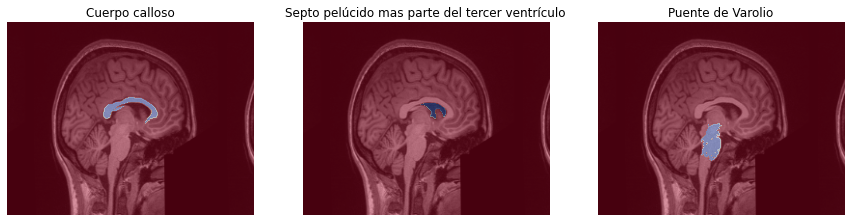

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(r1, cmap=plt.cm.gray)
plt.imshow(regiones, cmap='coolwarm_r', alpha=0.4)

plt.title('Cuerpo calloso'), plt.axis('off')
plt.subplot(132)
plt.imshow(r1, cmap=plt.cm.gray)
plt.imshow(regiones2, cmap='coolwarm_r', alpha=0.4)

plt.title('Septo pelúcido mas parte del tercer ventrículo'), plt.axis('off')

plt.subplot(133)
plt.imshow(r1, cmap=plt.cm.gray)
plt.imshow(regiones3,cmap='coolwarm_r', alpha=0.4)

plt.title('Puente de Varolio'), plt.axis('off')

Del mismo modo que en el anterior ejemplo, podemos comprobar que ajustando correctamente el intervalo de homogeneidad y posicionando correctamente la semilla podemos segmentar diferentes regiones anatómicas sin ningún problema.

## 4. Mejoras del algoritmo

Uno de los problemas más notorios que podemos encontrar con este algoritmo sería la variabilidad en el rango de grises que podría provocar el ruido de la imagen original. Por poner un ejemplo, imaginemos que tenemos una imagen con ruido impulsivo y emplazamos nuestra semilla en uno de los píxeles de "sal" que se encuentra en la sustancia gris de nuestra imagen. Este sería un outlier estadísticamente hablando. Si el pixel semilla tiene un valor de 1 (blanco), nuestro intervalo criterio de adición a la región estaría entre [0.85, 1.1] (en la práctica el rango superior sería 1, ya que no existen valores superiores en la imagen), lo que provocaría una mala segmentación.

Para solventar este problema una de las soluciones sería (aparte de preprocesar las imágenes mediante un filtro) el uso de áreas semilla posicionadas en la región a segmentar. Tras ello se realizaría una **estandarización de los valores de gris** obtenidos utilizando la media y la desviación típica de los píxeles de ese área. 
Sin embargo, la implementación de este tipo de algoritmos es bastante cara computacionalmente hablando.

## 4. Referencias


* Sustancia negra,  https://web.archive.org/web/20130930042749/http://www.neuroanatomy.wisc.edu/virtualbrain/BrainStem/20Substantia.html

* Sustancia blanca, https://medlineplus.gov/spanish/ency/article/002344.htm

* Sustancia gris, https://pubmed.ncbi.nlm.nih.gov/31990494/

**_Papers_** de referencia:
* Aminah Abdul Malek, Wan Eny Zarina Wan Abdul Rahman, Siti Salmah Yasiran, Abdul Kadir Jumaar y Ummu Mardhiah Abdul Jalit.(2012).*_Seed Point Selection for Seed-Based Region Growing in Segmenting Microcalcification_*:
    https://www.researchgate.net/publication/261389748_Seed_point_selection_for_seed-based_region_growing_in_segmenting_microcalcifications 
* Rolf Adams y Leanne Bischof.(1994).*_Seeded Region Growing_*:,
    https://pdfs.semanticscholar.org/db44/31b2a552d0f3d250df38b2c60959f404536f.pdf

## 5. Autoría
Esta práctica ha sido realizada por **Mariana Nakagawa, María Pardo y Gema Pérez**. Consideramos que las aportaciones de cada una en todos los puntos del trabajo se deben tener en cuenta. Hemos colaborado todas en la elaboración de cada algoritmo y en la solución de problemas.